# Fine-tuning an image generation model

In this notebook we will fine-tune the Titan Image Generator model using this [dataset](https://huggingface.co/datasets/gigant/oldbookillustrations).

## Prerequisites

We will install required libraries first. We also need:

* The name of an S3 bucket to use for images and the fine-tuning job
* The prefix in the bucket to store images in

We will read these values from a file called `config.yaml`. It must be in this format:

    s3:
        bucket: "my_bucket"
        prefix: "images"
        ftout: "imageft"
    bedrock:
        ftrole: "bedrock_role_arn"

In [2]:
!pip install --upgrade --force-reinstall --no-cache boto3
!pip install --upgrade --force-reinstall --no-cache botocore
!pip install --upgrade --force-reinstall --no-cache awscli
!pip install --upgrade --force-reinstall --no-cache datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 174.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 261.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 294.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 178.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.1
    Uninstalling urllib3-2.2.1:
      Successfully uninstalled urllib3-2.2.1
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: jmespath
    Found existing installation: jmespath 1.0.1
    Uninstalling jmespath-1.0.1:
      Successfully uninstalled jmespath-1.0.1
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0.post0
    Uninstalling python-date

In [3]:
import json
import boto3
import datetime
import time

In [15]:
import yaml
with open("config.yaml", 'r') as stream:
    cfg = yaml.safe_load(stream)

In [5]:
bucket_name = cfg['s3']['bucket']
s3_bucket_path = "s3://{}".format(bucket_name)
print("S3 bucket path: {}".format(s3_bucket_path))

S3 bucket path: s3://rd-search


In [6]:
s3_client = boto3.client('s3')

## Load data

Let's load the data using the `datasets` library and inspect one row of data.

In [7]:
from datasets import load_dataset

dataset = load_dataset("gigant/oldbookillustrations")

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [8]:
dataset['train'][0]

{'rawscan': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2281x3253>,
 '1600px': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1158x1600>,
 'info_url': 'https://www.oldbookillustrations.com/illustrations/making-friends/',
 'info_src': 'https://www.oldbookillustrations.com/wp-content/uploads/2022/08/making-friends-220x220.jpg',
 'info_alt': 'A bald man with a long beard smiles faintly as he carries on his back a little girl wearing his hat',
 'artist_name': 'Boughton, George Henry',
 'artist_birth_date': '1833',
 'artist_death_date': '1905',
 'artist_countries': ['US'],
 'book_title': 'Rip Van Winkle; and, The legend of Sleepy Hollow',
 'book_authors': ['Irving, Washington'],
 'book_publishers': ['Macmillan and Co.'],
 'date_published': '1907',
 'openlibrary-url': 'https://openlibrary.org/books/OL7142295M/Rip_Van_Winkle_and_The_legend_of_Sleepy_Hollow',
 'tags': ['1900s',
  '20th century',
  'black & white',
  'child',
  'happy',
  'mixed genders',
  'Rip Van Winkle'],

In [9]:
dataset['train'][0]['image_description']

'A bald man with a long gray beard smiles a faint and dreamy smile while carrying on his back a little girl who wears his hat.\n'

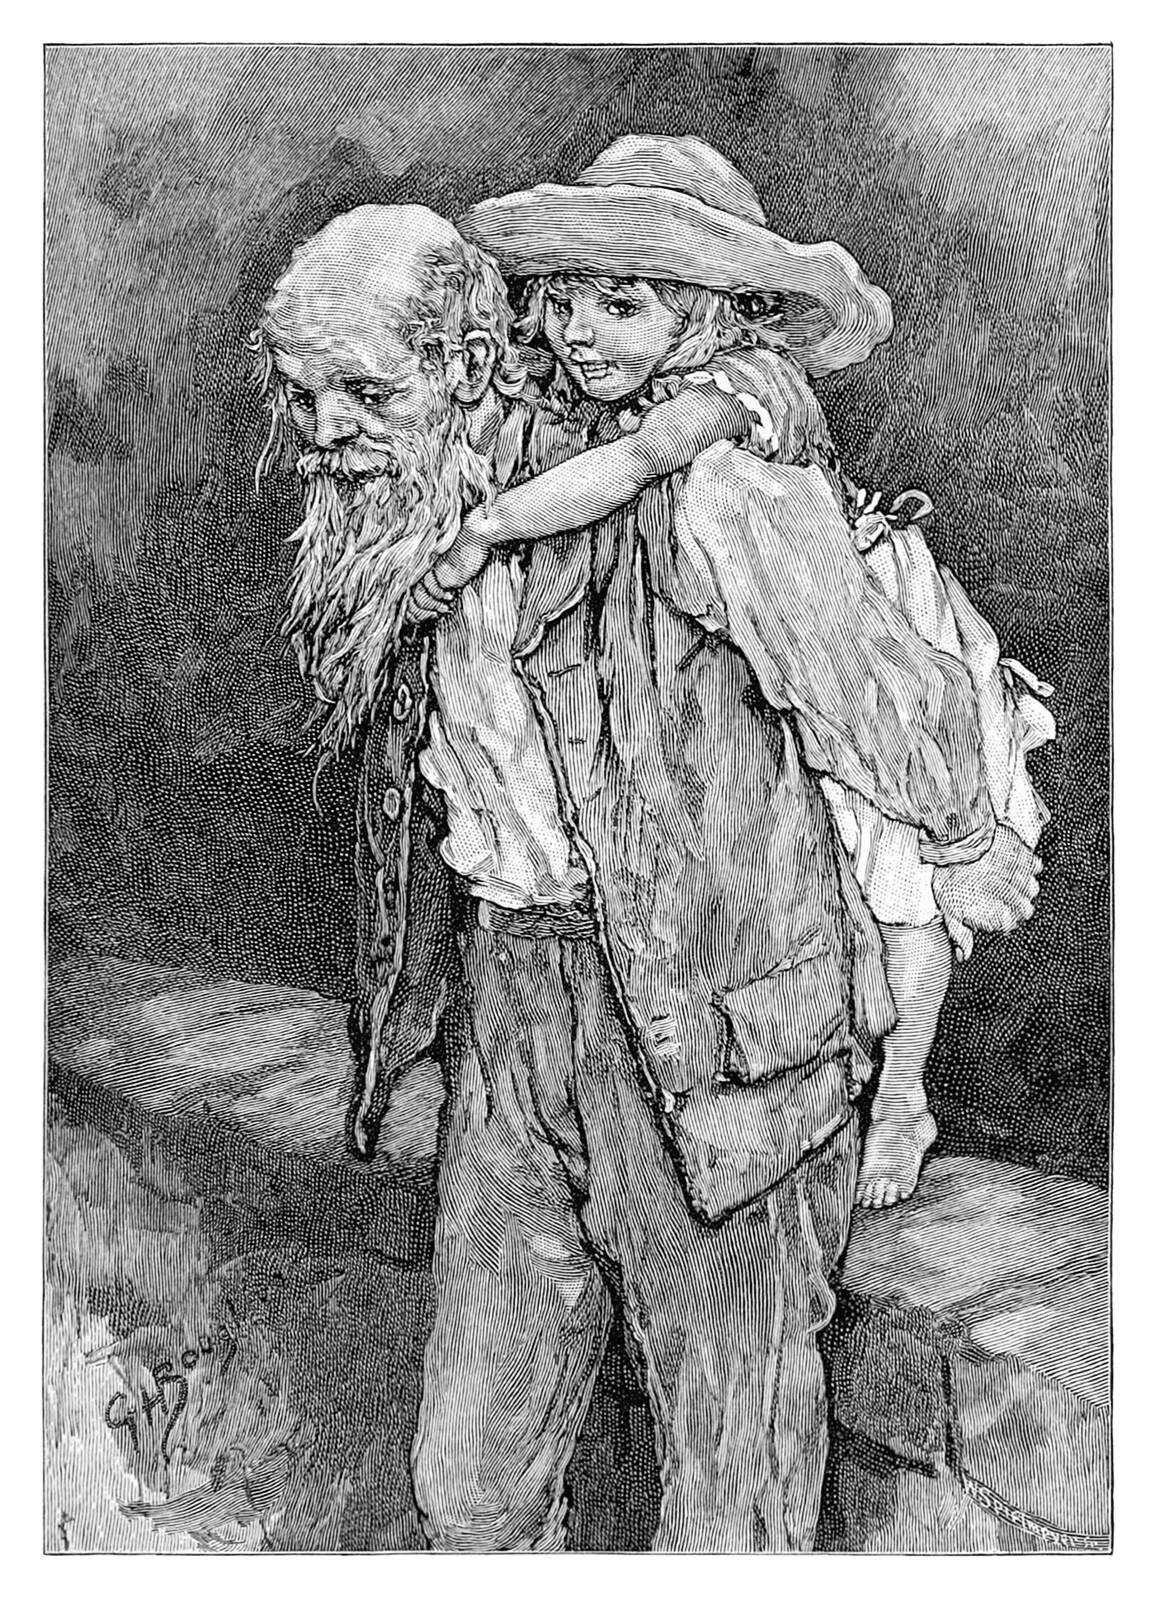

In [10]:
dataset['train'][0]['1600px']

## Upload data to s3

We'll loop through the dataset and process each row. We need to store each image locally and then upload it to s3. 

We also check the image aspect ratio, as it cannot be less than 1:4 or more than 4:1. See [Bedrock fine-tuning quotas](https://docs.aws.amazon.com/bedrock/latest/userguide/quotas.html#quotas-model-customization) for more details.

Then we'll write a JSON lines file where each line store a path to the image in s3 and the associated caption.

    {"image-ref": "s3://bucket/path/to/image001.png", "caption": "<prompt text>"}

In [11]:
import os

images_dir = 'images'

os.makedirs(images_dir, exist_ok=True)

In [33]:
import math

# Image dimensions must be between 512 and 4,096
# Aspect ratio must be between 1:4 and 4:1
def check_and_resize_image(img, min_size=512, max_size=4096, min_ratio=0.25, max_ratio=4.0):
    """
    Check if an image meets the specified size and aspect ratio requirements.
    If not, resize the image while maintaining the original aspect ratio.

    Args:
        image_path (str): Path to the image file.
        min_size (int): Minimum allowed size (height and width) in pixels (default=512).
        max_size (int): Maximum allowed size (height and width) in pixels (default=4096).
        min_ratio (float): Minimum allowed aspect ratio (width/height) (default=0.25).
        max_ratio (float): Maximum allowed aspect ratio (width/height) (default=4.0).

    Returns:
        PIL.Image: Resized image if the original image did not meet the requirements, otherwise the original image.
    """
    
    # Get the original size and aspect ratio
    width, height = img.size
    aspect_ratio = width / height

    # Check if the image meets the size and aspect ratio requirements
    if min_size <= width <= max_size and min_size <= height <= max_size and min_ratio <= aspect_ratio <= max_ratio:
        return img  # Image meets the requirements, return the original image

    # Resize the image while maintaining the aspect ratio
    if aspect_ratio > 1:  # Landscape
        new_width = min(max_size, max(min_size, width))
        new_height = int(new_width / aspect_ratio)
    else:  # Portrait
        new_height = min(max_size, max(min_size, height))
        new_width = int(new_height * aspect_ratio)

    # Resize the image
    resized_image = img.resize((new_width, new_height))

    return resized_image

In [32]:
# Make sure captions only have valid ASCII.
# Captions must be between 3 and 1024 characters in length.
def clean_caption(c):
    c_ascii = c.encode('ascii', errors='ignore').decode()
    if len(c_ascii) < 3:
        c_ascii = c_ascii + "   "
    if len(c_ascii) > 1024:
        c_ascii = c_ascii[0:1000]
    return c_ascii

In [37]:
max_images_to_use = 100
cnt = 0
output_file = 'finetune.jsonl'
with open(output_file, "w", encoding="utf-8") as jsonl_file:
    for d in dataset['train']:
        
        if cnt > max_images_to_use:
            print("Max images processed")
            break
        elif cnt % 10 == 0:
            print(f"{cnt}...")
            
        caption = d['image_description']
        img = check_and_resize_image(d['1600px'])
        local_jpg_path = os.path.join(images_dir, f"{cnt}.jpg")
        s3_jpg_path = os.path.join(cfg['s3']['prefix'], f"{cnt}.jpg")
        img.save(local_jpg_path)
        s3_image_path = "{}/{}".format(s3_bucket_path, s3_jpg_path)
        jsonl_entry = {
            "image-ref":s3_image_path,
            "caption": clean_caption(caption)
        }
        jsonl_file.write(json.dumps(jsonl_entry) + "\n")
        s3_client.upload_file(local_jpg_path, bucket_name, s3_jpg_path)
        
        cnt = cnt + 1
        
    jsonl_file.seek(jsonl_file.tell() - 1)
    jsonl_file.truncate()

s3_jsonl_path = os.path.join(cfg['s3']['prefix'], output_file)
s3_client.upload_file(output_file, bucket_name, s3_jsonl_path)
print(f"Processed {cnt-1} images")

0...
10...
20...
30...
40...
50...
60...
70...
80...
90...
100...
Max images processed
Processed 100 images


## Run fine-tuning job

In [38]:
ts = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Select the foundation model you want to customize (you can find this from the "modelId" from listed foundation model above)
base_model_id = "amazon.titan-image-generator-v1:0"

# Select the customization type from "FINE_TUNING" or "CONTINUED_PRE_TRAINING". 
customization_type = "FINE_TUNING"

# Specify the roleArn for your customization job
customization_role = cfg['bedrock']['ftrole']

# Create a customization job name
customization_job_name = f"image-gen-ft-{ts}"

# Create a customized model name for your fine-tuned Llama2 model
custom_model_name = f"image-gen-ft-{ts}"

# Define the hyperparameters for fine-tuning Llama2 model
hyper_parameters = {
    "stepCount": "8000",
    "batchSize": "8",
    "learningRate": "0.00001",
}

# Specify your data path for training, validation(optional) and output
s3_train_uri = s3_bucket_path + "/" + s3_jsonl_path
training_data_config = {"s3Uri": s3_train_uri}


output_data_config = {"s3Uri": f"s3://{bucket_name}/{cfg['s3']['ftout']}/output-{custom_model_name}"}

In [39]:
bedrock_client = boto3.client('bedrock')

# Create the customization job
bedrock_client.create_model_customization_job(
    customizationType=customization_type,
    jobName=customization_job_name,
    customModelName=custom_model_name,
    roleArn=customization_role,
    baseModelIdentifier=base_model_id,
    hyperParameters=hyper_parameters,
    trainingDataConfig=training_data_config,
    outputDataConfig=output_data_config
)

{'ResponseMetadata': {'RequestId': '36c491a5-d4bd-46d2-ba4c-e7f72b10a93f',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Mon, 18 Mar 2024 15:06:33 GMT',
   'content-type': 'application/json',
   'content-length': '122',
   'connection': 'keep-alive',
   'x-amzn-requestid': '36c491a5-d4bd-46d2-ba4c-e7f72b10a93f'},
  'RetryAttempts': 0},
 'jobArn': 'arn:aws:bedrock:us-west-2:102165494304:model-customization-job/amazon.titan-image-generator-v1:0/n8m3edc5m5bn'}

### Waiting until customization job is completed

Check in the Bedrock console for the job to finish. It may take several hours to run.

## Compare model output

In [41]:
import boto3
import io
import json
import base64
import numpy as np
from PIL import Image
from ipywidgets import Dropdown
import matplotlib.pyplot as plt

bedrock = boto3.client('bedrock')
bedrock_runtime = boto3.client('bedrock-runtime')

In [42]:
customization_jobs = {}
dropdown_vals = []
for cj in bedrock.list_model_customization_jobs()["modelCustomizationJobSummaries"]:
    if cj["status"] == "Completed":
        customization_jobs[cj["customModelName"]] = cj
        dropdown_vals.append(cj["customModelName"] + " - creationTime: " + cj["creationTime"].strftime("%Y-%m-%d %H:%M:%S"))

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=dropdown_vals,
    value=dropdown_vals[0],
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

Dropdown(description='Select a model', layout=Layout(width='max-content'), options=('image-gen-ft-2024-03-18-1…

In [43]:
selected_model = model_dropdown.value.split(" - creationTime: ")[0]
custom_model_name, custom_model_arn = selected_model, customization_jobs[selected_model]["customModelArn"]
custom_model_name, custom_model_arn

('image-gen-ft-2024-03-18-15-06-31',
 'arn:aws:bedrock:us-west-2:102165494304:custom-model/amazon.titan-image-generator-v1:0/frfsqxazgqbu')

In [44]:
provisioned_model_id = bedrock.create_provisioned_model_throughput(
    modelUnits=1,
    # create a name for your provisioned throughput model
    provisionedModelName=custom_model_name, 
    modelId=custom_model_arn
)['provisionedModelArn']

In [ ]:
%%time
# check provisioned throughput job status
import time
status_provisioning = bedrock.get_provisioned_model_throughput(provisionedModelId = provisioned_model_id)['status'] 
while status_provisioning == 'Creating':
    time.sleep(60)
    status_provisioning = bedrock.get_provisioned_model_throughput(provisionedModelId=provisioned_model_id)['status']
    print(status_provisioning)

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating


In [60]:
prompts = [
    dataset['train'][0]['image_description'],
    dataset['train'][5]['image_description']
]
seeds = [0, 3000]
gt_images = [
    dataset['train'][0]['1600px'],
    dataset['train'][5]['1600px']
]

In [74]:
def decode_base64_image(img_b64):
    return Image.open(io.BytesIO(base64.b64decode(img_b64)))

def invoke_model_tgi(prompt, seed, model_arn):
    img_gen_conf = {
        "cfgScale": 8,
        "seed": seed,
        "quality": "standard",
        "width": 1024,
        "height": 1024,
        "numberOfImages": 2
    }

    body = json.dumps({
        "textToImageParams": {
            "text": prompt
        },
        "taskType": "TEXT_IMAGE",
        "imageGenerationConfig": img_gen_conf
    })

    response = bedrock_runtime.invoke_model(
        body=body,
        modelId=model_arn,
        accept="application/json",
        contentType="application/json"
    )

    response_body = json.loads(response.get("body").read())
    return [decode_base64_image(img) for img in response_body["images"]]

def compare_models_outputs(prompts, gt_images, seeds, model_arn_base, model_arn_custom):
    images = []
    for idx, prompt in enumerate(prompts):
        for seed in seeds:
            # Invoke the base model
            base_images = invoke_model_tgi(prompt, seed, model_arn_base)

            # Invoke the customized model
            custom_images = invoke_model_tgi(prompt, seed, model_arn_custom)

            # Display the images for comparison
            #plot_images(base_images, custom_images, gt_images[idx], prompt, seed)
            images.append((base_images[0], custom_images[0], gt_images[idx], prompt, seed))

    return images


In [75]:
images = compare_models_outputs(prompts, gt_images, seeds, "amazon.titan-image-generator-v1", provisioned_model_id)

In [76]:
images[0]

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1158x1600>,
 'A bald man with a long gray beard smiles a faint and dreamy smile while carrying on his back a little girl who wears his hat.\n',
 0)

In [82]:
plt.clf()

<Figure size 640x480 with 0 Axes>

In [85]:
def plot_images(base_image, custom_image, gt_image, prompt, seed):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(np.array(base_image))
    axes[0].set_title('Base Model\nSeed: {}'.format(seed))
    axes[0].axis('off')

    axes[1].imshow(np.array(custom_image))
    axes[1].set_title('Custom Model\nSeed: {}'.format(seed))
    axes[1].axis('off')
    
    axes[2].imshow(np.asarray(gt_image))
    axes[2].set_title('Ground truth')
    axes[2].axis('off')
    
    print("Prompt:{}\n".format(prompt))
    plt.show()

Prompt:A bald man with a long gray beard smiles a faint and dreamy smile while carrying on his back a little girl who wears his hat.




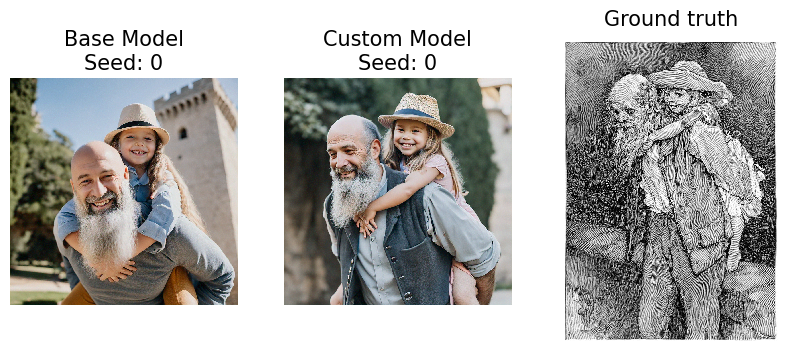

Prompt:A bald man with a long gray beard smiles a faint and dreamy smile while carrying on his back a little girl who wears his hat.




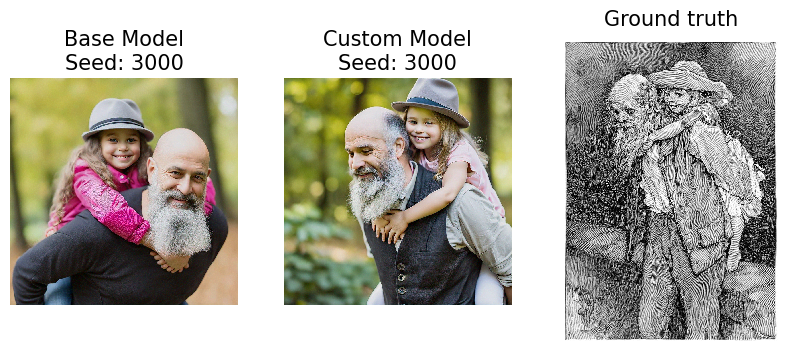

Prompt:An old man lies in the woods, fast asleep and clutching his rifle, unaware of the figure of Father Time leaning over him with one hand raised to his forehead, as though perplexed, and the other holding his scythe.




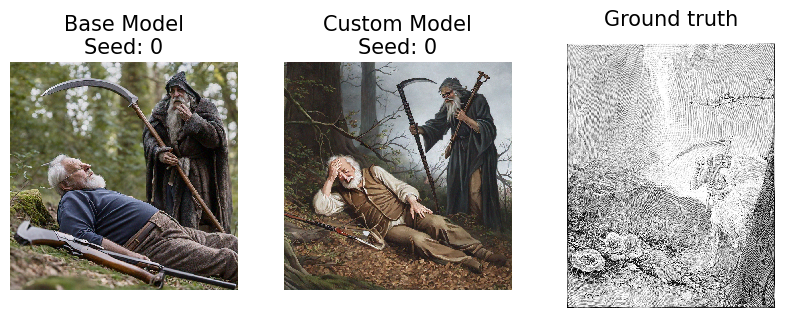

Prompt:An old man lies in the woods, fast asleep and clutching his rifle, unaware of the figure of Father Time leaning over him with one hand raised to his forehead, as though perplexed, and the other holding his scythe.




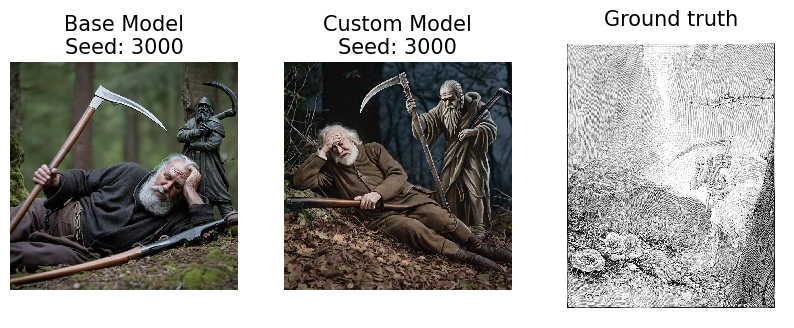

In [86]:
for i in images:
    b, c, g, p, s = i
    plot_images(b,c,g,p,s)

# Cleanup

In [87]:
bedrock.delete_provisioned_model_throughput(provisionedModelId=provisioned_model_id)

{'ResponseMetadata': {'RequestId': 'd853ab08-ffb2-4e0f-8955-f0c1ff643a33',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 18 Mar 2024 20:31:16 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'd853ab08-ffb2-4e0f-8955-f0c1ff643a33'},
  'RetryAttempts': 0}}